Press Ctrl C together anytime to end analysis 

Length of recording in seconds:  284
Total number of data points:  12536823
Sampling rate in Hertz:  44100.0
Time step in milliseconds:  0.022675736961451247
Maximum absolute height of spikes 0.556182861328125


*************   Selection parameters *********************


1: Height 2: Negative height 

3: Half positive width 4: Full positive width 

5: Half negative width 6: Full negative width  

7: Positive area 8: Negative area 9: Total area

10: Distance between positive and negative peaks 

********************************************************** 



Enter 0 for manual selection or 1 to use Principal Component Analysis 1
Enter 1 to plot total signal, 0 to continue 1
Since the recording is very large 12536823
Plot every d points of recording 10


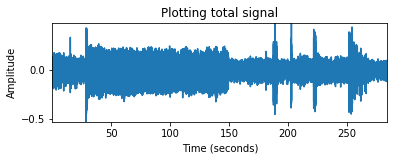

<Figure size 432x288 with 0 Axes>

Start time needs to be greater than 0 and less than total time 284
Enter start time (in seconds) to begin analysis2
End time needs to be greater than start time d and less than total time 2 284
Enter end time (in seconds) at which to end analysis 10
Spike threshold needs to be greater than 0 and less than the maximum spike height 0.556182861328125
Enter minimum threshold for spikes to be considered for analysis .13
Threshold in spike sorting algorithm 0.13
Extracting recording from start time to end time


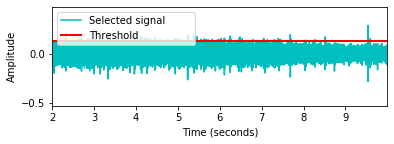

Are you satisfied with your choice of the spike threshold and start and end times for analysis? 

Enter 0: No (program will end and can be rerun) OR 1: Yes 1
Finding location of peaks 

Number of peaks above threshold 
 
 191
Coefficient of variation of Positive spike height [0.12628219]
Coefficient of variation of Negative spike height [0.31805883]
Coefficient of variation of Positive half-width [0.11031489]
Coefficient of variation of Positive full-width [0.191518]
Coefficient of variation of Negative half-width [0.20703315]
Coefficient of variation of Negative full-width [0.23818856]
Coefficient of variation of Positive area [0.19378164]
Coefficient of variation of Negative area [0.37905742]
Coefficient of variation of Total area [0.17110877]
Coefficient of variation of Time between peaks [0.69324768]


First selection criteria  PCA Score 1
Second selection criteria  PCA Score 2


In [1]:
###### Import Libraries
import numpy as np
import pandas as pd
import math 
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import scipy.io.wavfile as wav
from scipy.io.wavfile import read as read_wav
import os
import soundfile as sf
from numpy import sqrt 
from numpy import array
from scipy.linalg import svd

'''Read Recording'''

filename="Experiment.wav" #Change to filename

os.chdir(r"D:\Ricoy") # change to the file directory
ya, fs = sf.read(filename) #Input the .wav file recording

dt = 1./fs #Time between recordings 
n = len(ya) #Number of recordings

totaltime = int(n*dt)         #Total time of recording 
print('Press Ctrl C together anytime to end analysis \n')
print('Length of recording in seconds: ',totaltime)
print('Total number of data points: ',n)
print('Sampling rate in Hertz: ',1.0/dt)
print('Time step in milliseconds: ',1000*dt)        #Print recording properties

'''End: Read in recording'''

yamax = max(abs(ya));

print('Maximum absolute height of spikes',yamax)  #Maximum absolute height of spikes
     
'''Set parameters for analysis'''
 
num_selections = 2 # Number of features to use for spike sorting
#totalsignal = 0 # Set totalsignal = 1 to plot the entire recording

#Parameter which manages addition of points to cluster, Suggested range: [.25,1.5]
fraction_radius_group_orig = .6
fraction_radius_group = fraction_radius_group_orig

#Parameter which manages distance between clusters, Suggested range: [.25,1]
fraction_radius_all_scores_orig = 0.5
fraction_radius_all_scores = fraction_radius_all_scores_orig

# Parameter which regulates the minimum distance the points of one cluster
#can be to another cluster
minimum_distance_cluster_parameter_orig = .125
minimum_distance_cluster_parameter_orig = .25
minimum_distance_cluster_parameter = minimum_distance_cluster_parameter_orig

ijump = 10  #Gap between spike data to read 

# Spike features to select from to do analysis
print('\n')
print('*************   Selection parameters *********************')
print('\n')
print('1: Height 2: Negative height \n');
print('3: Half positive width 4: Full positive width \n');
print('5: Half negative width 6: Full negative width  \n');
print('7: Positive area 8: Negative area 9: Total area\n');
print('10: Distance between positive and negative peaks \n');
print('********************************************************** \n')
print('\n')

stra=np.array(['Positive spike height','Negative spike height','Positive half-width','Positive full-width',
'Negative half-width','Negative full-width','Positive area','Negative area','Total area'
,'Time between peaks','PCA Score 1','PCA Score 2'])   #Spike properties to display stored in array called stra

pca_temp = -1
nit = 0
while (pca_temp != 0 and pca_temp != 1):
   nit = nit + 1
   if (nit > 1):
      print('Please enter 0 or 1')  
   pca_temp = int(input('Enter 0 for manual selection or 1 to use Principal Component Analysis '))
pca = pca_temp

selection=np.zeros((10,1))
if (pca == 0):
    for ijk in [0,1]:
        if (ijk == 0):
           iii = 0
           while (iii > 10 or iii < 1):
              iii = int(input('Enter number for selection criteria 1: '))
              print('Value needs to be between 1 and 10 \n')
           selection[ijk] = iii
        else:
           iii = 0
           while (iii > 10 or iii < 1):
              iii = int(input('Enter number for selection criteria 2: '))
              print('Value needs to be between 1 and 10 \n')
           selection[ijk] = iii 

if (pca == 1):
   selection[0] = 11
   selection[1] = 12

#End: Set parameters for analysis 

#Plot recording, Select start and end times for analysis

totalsignal = int(input('Enter 1 to plot total signal, 0 to continue '))

if (totalsignal == 1): 
   ifirst = int(1)
   ilast = int(n)
   if (n > 1000000):
      print('Since the recording is very large' ,n)
      print('Plot every d points of recording',ijump)
      ijump = int(10)
   
   xpkt = np.arange(ifirst,ilast,ijump)
   ypkt = ya[np.arange(ifirst-1,ilast,ijump)]
   xpkt1 = np.reshape(xpkt, (len(xpkt), 1))
   xpkt = xpkt1*dt
   axmin = float(ifirst)*dt
   axmax = float(ilast)*dt
   ypkmin = min(ypkt)
   ypkmax = max(ypkt)
   matplotlib.pyplot.subplot(2,1,1)
   plt.plot(xpkt,ypkt)
   plt.axis([axmin, axmax, ypkmin, ypkmax])   
   plt.title("Plotting total signal")
   plt.xlabel("Time (seconds)")
   plt.ylabel("Amplitude")
   plt.figure()
   plt.show()

starttime_temp = -1

while (int(starttime_temp) < int(0) or int(starttime_temp) >= int(totaltime)):
    print('Start time needs to be greater than 0 and less than total time',totaltime)
    starttime_temp = int(input('Enter start time (in seconds) to begin analysis'))
starttime = starttime_temp
endtime_temp = starttime
while(int(endtime_temp) <= int(starttime) or int(endtime_temp) > int(totaltime)):
    print('End time needs to be greater than start time d and less than total time',starttime,totaltime)
    endtime_temp = int(input('Enter end time (in seconds) at which to end analysis '))
endtime = endtime_temp
threshold_temp = -1.
while (float(threshold_temp)< float(0) or float(threshold_temp) > float(yamax)):
    print('Spike threshold needs to be greater than 0 and less than the maximum spike height',yamax)
    threshold_temp = float(input('Enter minimum threshold for spikes to be considered for analysis '))
threshold = threshold_temp
    
print('Threshold in spike sorting algorithm' ,threshold)
  
mstart=int(np.floor(max(np.floor(starttime/dt)+1,2))) # Beginning integer recording value corresponding to start time

mfinish = int(np.floor(endtime/dt)) # End integer recording value corresponding to end time

ioverlay = 1 #Set overlay = 1 to create plot of overlayed spikes

print('Extracting recording from start time to end time')
minypk = 1e20
maxypk = -1e20

xpk=np.arange(mstart*dt-dt,mfinish*dt,dt)
xpk=np.reshape(xpk, (len(xpk), 1))
ypk = ya[mstart-1:mfinish:1]
ypk=np.reshape(ypk, (len(ypk), 1))

nelem = mfinish - mstart + 1
if (nelem > 1000000):
  ijump_selection = 10
else:
  ijump_selection = 1

xpk_plot = xpk[0:nelem:ijump_selection]
ypk_plot = ypk[0:nelem:ijump_selection]


if (totalsignal == 1):
   plt.plot(xpk_plot,ypk_plot,'c-')
   plt.axis([axmin,axmax,ypkmin,ypkmax])  

xp_threshold = np.zeros((2,1))
xp_threshold[0] = xpk[1]
yp_threshold  = np.zeros((2,1))
yp_threshold[0] = threshold
xp_threshold[1] = xpk[mfinish-mstart-1]
yp_threshold[1] = threshold
if (totalsignal == 1):
   matplotlib.pyplot.matplotlib.pyplot.subplot(2,1,2)

plt.plot(xpk_plot,ypk_plot,'c-') 
if (totalsignal == 1):
   plt.axis([min(xpk_plot),max(xpk_plot),ypkmin,ypkmax])
            
plt.plot(np.array(list(xp_threshold)),np.array(list(yp_threshold)),'r-',linewidth=2)
plt.legend(['Selected signal        ','Threshold','Orientation','horizontal','Location','South'],loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

print('Are you satisfied with your choice of the spike threshold and start and end times for analysis? \n')
ithreshold = int(input('Enter 0: No (program will end and can be rerun) OR 1: Yes '));

### End: Plot recording, Select start and end times for analysis

'''Find location of peaks'''

print('Finding location of peaks \n') 

istart = 0
ilocation = 0
ypkmax = 0
ijk = 0

peak = np.zeros((mfinish-mstart+1,1)) # Stores the recordings where the peaks occur
ya = np.reshape(ya, (len(ya), 1))

peak_pre=np.zeros((100000,1))
height_pre=np.zeros((100000,1))
peak_int=np.zeros((100000,1))

for i in np.arange(mstart, mfinish+1) : 
    if (abs(ya[i,0]) < threshold):
       istart = 1
    if (abs(ya[i,0]) > threshold and istart == 1):
       if (abs(ya[i,0]) > ypkmax):
          ypkmax = abs(ya[i,0])
          ilocation = i
    if (ilocation > 0):
       if (abs(ya[i-1,0]) >= .5*threshold and abs(ya[i,0]) <= .5*threshold and istart == 1):
          ijk = ijk + 1
          
          if (np.mod(ijk,400) == 0):
             print('Number of peaks (positive or negative) found above threshold \n',ijk)
          peak_pre[ijk-1] = ilocation+1
          height_pre[ijk-1] = ya[ilocation,0]

          facya = .5*(ya[ilocation+1,0] - ya[ilocation-1,0])/(ya[ilocation+1,0]-2.0*ya[ilocation,0]+ya[ilocation-1,0])
          peak_int[ijk-1] = dt*(float(ilocation) - facya)
                    
          ypkmax = 0
          ilocation = 0
          istart = 0
        
npeaks = ijk
ifilter = 0
height=np.zeros((npeaks,1))

for ijk in range(0,npeaks):
    if (height_pre[ijk] > 0.0):
       ifilter = ifilter + 1
       peak[ifilter-1] = peak_pre[ijk]
       height[ifilter-1] = height_pre[ijk]
    else:
       iloc = peak_pre[ijk]
       if (ijk + 1 <= npeaks):
          iloc_ahead = peak_pre[ijk+1]
       else:
          iloc_ahead = -100000
       if (ijk - 1 >= 1):
          iloc_before = peak_pre[ijk-1]
       else:
          iloc_before = -100000
       time_ahead = float(iloc_ahead - iloc)*dt/1000. # time to next spike in ms
       time_before = float(iloc - iloc_before)*dt/1000. # time to previous spike in ms
       if (time_ahead <= 2.0 or time_before <= 2.0):
          too_close = 1 # Spike is within 2 ms of another spike
       else:
          too_close = 0
       max_allowed = np.floor(1.5/(dt*1000)) # Positive peak needs to be within 1.5 ms
       if (too_close == 0):
          # Search for positive peak
          ii = iloc
          ypkmax = 0.0
          ilocation = 0
          while (ii <= max_allowed):
              if (ya[ii,0] > ypkmax and ya[ii,0] >= .5*threshold):
                 ypkmax = ya[ii,0]
                 ilocation = ii
              ii = ii + 1
          ilocation
        
npeaks = ifilter
       
print('Number of peaks above threshold \n \n',npeaks)

if (npeaks < 10):
   print('Number of peaks may be too few to do a spike sorting analysis \n')
   print('Try decreasing threshold or increasing time range \n')
   print('Ending progam \n')

firstzero=np.zeros((npeaks,1))
firstzero_int=np.zeros((npeaks,1))
beginpeak=np.zeros((npeaks,1))
beginpeak_int=np.zeros((npeaks,1))
heightnegative=np.zeros((npeaks,1))
negpeak=np.zeros((npeaks,1))
areaneg=np.zeros((npeaks,1))
negpeak_int=np.zeros((npeaks,1))
endpeak=np.zeros((npeaks,1))
endpeak_int=np.zeros((npeaks,1))
areapos=np.zeros((npeaks,1))
areatot=np.zeros((npeaks,1))
firstneg=np.zeros((npeaks,1))
firstneg_int=np.zeros((npeaks,1))
secondneg=np.zeros((npeaks,1))
secondneg_int=np.zeros((npeaks,1))
beghalfheight=np.zeros((npeaks,1))
beghalfheight_int=np.zeros((npeaks,1))
endhalfheight=np.zeros((npeaks,1))
endhalfheight_int=np.zeros((npeaks,1))
heightnegative=np.zeros((npeaks,1))

for kk in range(0,npeaks):
    ijk = 0
    firstzerol = 0
    secondpeak = 0
    heightnegative[kk] = 1E10      
          
    for j in range(int(peak[kk])-1,int(peak[kk])-200,-1) :
        if (ya[j,0] >= 0 and ya[j-1,0] <= 0 and firstzerol == 0 and secondpeak == 0):
           firstzerol = 1
           firstzero[kk] = j+1 # firstzero stores the location of first zero to left of peak
           firstzero_int[kk] = dt*( float(j-1) + (0. - ya[j-1,0])/(ya[j,0] - ya[j-1,0]) )

        if (ya[j,0] <= 0. and ya[j-1,0] >= 0. and firstzerol == 1 and secondpeak == 0):
           beginpeak[kk] = j+1 # beginpeak stores the second zero to left of peak
           beginpeak_int[kk] = dt*( float(j-1) + (0. - ya[j-1,0])/(ya[j,0] - ya[j-1,0]) )
           secondpeak = 1
    beginpeak[kk] = max(beginpeak[kk],peak[kk]-200)

    heightnegative[kk] = 1E10
    areaneg[kk] = 0
    for j in range(int(beginpeak[kk])-1,int(firstzero[kk])):
        if (ya[j,0] <= heightnegative[kk]):
           heightnegative[kk] = ya[j,0] # stores location of negative peak
           negpeak[kk] = j+1                   
        areaneg[kk] = areaneg[kk] + abs(ya[j,0])
        
    heightnegative=heightnegative[0:npeaks]             
    jlo = int(negpeak[kk])
    facya = .5*(ya[jlo+1,0] - ya[jlo-1,0])/(ya[jlo+1,0]-2.0*ya[jlo,0]+ya[jlo-1,0])
    negpeak_int[kk] = dt*(float(jlo) - facya)
    
    firstzeror = 0
    for j in range(int(peak[kk])+5-1, int(peak[kk])+100):
        #if (ya[j-1,0] >= 0. and ya[j,0] <= 0. and firstzeror == 0)
        if (ya[j,0] > ya[j-1,0] and firstzeror == 0):
           endpeak[kk] = j+1 # endpeak stores location of zero to right of peak
           facya = .5*(ya[j,0] - ya[j-2,0])/(ya[j,0]-2.0*ya[j-1,0]+ya[j-2,0])
           endpeak_int[kk] = dt*(float(j-1) - facya)
           firstzeror = 1
    endpeak[kk] = min(endpeak[kk],peak[kk]+100) 
    
    areapos[kk] = 0
    for j in range(int(firstzero[kk])-1,int(endpeak[kk])):
        areapos[kk] = areapos[kk] + abs(ya[j,0])
          
    halfheightnegative = float(.5*heightnegative[kk])
              
    for j in range(int(beginpeak[kk])-1,int(firstzero[kk])):
        if (ya[j-1,0] >= halfheightnegative and ya[j,0] <= halfheightnegative):
           firstneg[kk] = j+1 # firstneg and secondneg store locations of negative half height
           firstneg_int[kk] = dt*( float(j-1) + (halfheightnegative - ya[j-1,0])/(ya[j,0] - ya[j-1,0]))
                   
        if (ya[j-1,0] <= halfheightnegative and ya[j,0] >= halfheightnegative):
           secondneg[kk] = j+1
           secondneg_int[kk] = dt*( float(j-1) + (halfheightnegative - ya[j-1,0])/(ya[j,0] - ya[j-1,0]))
         
    halfheight = .5*height[kk]
    
    for j in range(int(firstzero[kk])-1,int(peak[kk])) :
        if (ya[j-1,0] <= halfheight and ya[j,0] >= halfheight):
           beghalfheight[kk] = j+1 # beghalfheight and endhalfheight store locations of positive half height
           beghalfheight_int[kk] = dt*( float(j-1) + (halfheight - ya[j-1,0])/(ya[j,0] - ya[j-1,0]) )
          
    for j in range(int(peak[kk]),int(endpeak[kk])):
        if (ya[j-1,0] >= halfheight and ya[j,0] <= halfheight) :
           endhalfheight[kk] = j+1 
           endhalfheight_int[kk] = dt*( float(j-1) + (halfheight - ya[j-1,0])/(ya[j,0] - ya[j-1,0]) ) 

maxdistb = -1.

for kk in range(0,npeaks):
    distancebeginpeak = peak[kk] - beginpeak[kk] 
    maxdistb = max(maxdistb,distancebeginpeak)

ap_before = .5
ap_after = .2

maxdistb = np.floor(ap_before/(1000*dt))
   
maxdiste = -1.
for kk in range(0,npeaks) :
    distanceendpeak = endpeak[kk] - peak[kk]   
    maxdiste = max(maxdiste,distanceendpeak)

maxdiste = np.floor(ap_after/(1000*dt))

halfposheightdur=np.zeros((npeaks,1))
fullposheightdur=np.zeros((npeaks,1))
halfnegheightdur=np.zeros((npeaks,1))
fullnegheightdur=np.zeros((npeaks,1))
distancepeaks=np.zeros((npeaks,1))
areatot=np.zeros((npeaks,1))

for kk in (range(0,npeaks)):
    halfposheightdur[kk] = float(endhalfheight[kk]-beghalfheight[kk])*dt
    halfposheightdur[kk] = endhalfheight_int[kk] - beghalfheight_int[kk]

    fullposheightdur[kk] = float(endpeak[kk]-firstzero[kk])*dt
    fullposheightdur[kk] = endpeak_int[kk] - firstzero_int[kk]

    halfnegheightdur[kk] = float(secondneg[kk]-firstneg[kk])*dt 
    halfnegheightdur[kk] = secondneg_int[kk] - firstneg_int[kk] 

    fullnegheightdur[kk] = float(firstzero[kk]-beginpeak[kk])*dt
    fullnegheightdur[kk] = firstzero_int[kk] - beginpeak_int[kk]
                
    distancepeaks[kk] = float(peak[kk] - negpeak[kk])*dt
    distancepeaks[kk] = peak_int[kk] - negpeak_int[kk]

    areapos[kk] = areapos[kk]*dt
    areaneg[kk] = areaneg[kk]*dt
    areatot[kk] = areapos[kk] + areaneg[kk]
    
height=height[0:npeaks]
#########################################################################            
#  End: Determining other features of action potential
#########################################################################

#########################################################################            
#  Normalize features of action potential
#########################################################################

heightmean = np.mean(height)
heightsd = np.std(height)
   
heightnegativemean = np.mean(heightnegative)
heightnegativesd = np.std(heightnegative)
   
areaposmean = np.mean(areapos)
areapossd = np.std(areapos)
   
areanegmean = np.mean(areaneg)
areanegsd = np.std(areaneg)
   
areatotmean = np.mean(areatot)
areatotsd = np.std(areatot)
   
halfposheightdurmean = np.mean(halfposheightdur)
halfposheightdursd = np.std(halfposheightdur)
   
fullposheightdurmean = np.mean(fullposheightdur)
fullposheightdursd = np.std(fullposheightdur)
   
halfnegheightdurmean = np.mean(halfnegheightdur)
halfnegheightdursd = np.std(halfnegheightdur)
    
fullnegheightdurmean = np.mean(fullnegheightdur)
fullnegheightdursd = np.std(fullnegheightdur)
   
distancepeaksmean = np.mean(distancepeaks)
distancepeakssd = np.std(distancepeaks)

# Normalize features of action potential

heightz=np.zeros((npeaks,1))
heightnegativez=np.zeros((npeaks,1))
areaposz=np.zeros((npeaks,1))
areanegz=np.zeros((npeaks,1))
areatotz=np.zeros((npeaks,1))
halfposheightdurz=np.zeros((npeaks,1))
fullposheightdurz=np.zeros((npeaks,1))
halfnegheightdurz=np.zeros((npeaks,1))
fullnegheightdurz=np.zeros((npeaks,1))
distancepeaksz=np.zeros((npeaks,1))

coefficient_variation=np.zeros((10,1))

for kk in range(0,npeaks):
    heightz[kk] = (height[kk] - heightmean)/heightsd
    heightnegativez[kk] = (heightnegative[kk] - heightnegativemean)/heightnegativesd
    areaposz[kk] = (areapos[kk] - areaposmean)/areapossd
    areanegz[kk] = (areaneg[kk] - areanegmean)/areanegsd
    areatotz[kk] = (areatot[kk] - areatotmean)/areatotsd
    halfposheightdurz[kk] = (halfposheightdur[kk] - halfposheightdurmean)/halfposheightdursd
    fullposheightdurz[kk] = (fullposheightdur[kk] - fullposheightdurmean)/fullposheightdursd
    halfnegheightdurz[kk] = (halfnegheightdur[kk] - halfnegheightdurmean)/halfnegheightdursd
    fullnegheightdurz[kk] = (fullnegheightdur[kk] - fullnegheightdurmean)/fullnegheightdursd
    distancepeaksz[kk] = (distancepeaks[kk] - distancepeaksmean)/distancepeakssd

coefficient_variation[0] = heightsd/heightmean
coefficient_variation[1] = -heightnegativesd/heightnegativemean
coefficient_variation[2] = abs(halfposheightdursd/halfposheightdurmean)
coefficient_variation[3] = fullposheightdursd/fullposheightdurmean
coefficient_variation[4] = halfnegheightdursd/halfnegheightdurmean
coefficient_variation[5] = fullnegheightdursd/fullnegheightdurmean
coefficient_variation[6] = areapossd/areaposmean
coefficient_variation[7] = areanegsd/areanegmean
coefficient_variation[8] = areatotsd/areatotmean
coefficient_variation[9] = abs(distancepeakssd/distancepeaksmean)

# Print out coefficient of variation from largest to smallest
for jj in range(0,10):
    print('Coefficient of variation of',stra[jj],coefficient_variation[jj])

#########################################################################            
#  End: Normalize features of action potential
#########################################################################
   
print('\n')   
print('First selection criteria ', stra[int(selection[0])-1])
print('Second selection criteria ', stra[int(selection[1])-1])

#########################################################################            
#           Manual  of Criteria
#########################################################################            

scorev =np.zeros((npeaks,num_selections))
scoreo =np.zeros((npeaks,num_selections))

if (pca == 0):
   for ijk in range(0,num_selections) :
       
       if (selection[ijk] == 1):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = heightz[kk]
              scoreo[kk,ijk] = height[kk]
            
       
                    
       if (selection[ijk] == 2):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = heightnegativez[kk]
              scoreo[kk,ijk] = heightnegative[kk]
           
       
                    
       if (selection[ijk] == 3):
          for kk in range(0, npeaks):
              scorev[kk,ijk] = halfposheightdurz[kk]
              scoreo[kk,ijk] = halfposheightdur[kk]
           
       
          
       if (selection[ijk] == 4):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = fullposheightdurz[kk]
              scoreo[kk,ijk] = fullposheightdur[kk]
           
       
          
       if (selection[ijk] == 5):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = halfnegheightdurz[kk]
              scoreo[kk,ijk] = halfnegheightdur[kk]
           
       
          
       if (selection[ijk] == 6):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = fullnegheightdurz[kk]
              scoreo[kk,ijk] = fullnegheightdur[kk]
           
       
                    
       if (selection[ijk] == 7):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = areaposz[kk]
              scoreo[kk,ijk] = areapos[kk]
           
       
          
       if (selection[ijk] == 8):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = areanegz[kk]
              scoreo[kk,ijk] = areaneg[kk]
           
       
          
       if (selection[ijk] == 9):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = areatotz[kk]
              scoreo[kk,ijk] = areatot[kk]
           
       
                    
       if (selection[ijk] == 10):
          for kk in range(0,npeaks):
              scorev[kk,ijk] = distancepeaksz[kk]
              scoreo[kk,ijk] = distancepeaks[kk]
                   
#########################################################################            
#           End: Manual Selection of Criteria
#########################################################################   


In [2]:
'''PRINCIPAL COMPONENT ANALYSIS'''

range_variable = int(maxdiste+maxdistb+1)
xpkk = np.zeros((range_variable+100,1))
ypkk = np.zeros((range_variable+100,1))
xmat = np.zeros((npeaks,range_variable))

for kk in range(0,npeaks):
       
    # beginpeak firstneg negpeak secondneg firstzero beghalfheight peak endhalfheight endpeak 
    ijk = 0
    if (int(peak[kk]-maxdistb) < int(beginpeak[kk]-1)):
        for j in range(int(peak[kk]-maxdistb)-1,int(beginpeak[kk])-1):
           ijk = ijk + 1
           xpkk[ijk-1] = ijk
           ypkk[ijk-1] = 0

    for j in range(int(firstneg[kk])-1,int(peak[kk])):
        ijk = ijk +1
        xpkk[ijk-1] = ijk
        ypkk[ijk-1] = ya[j,0]
        
    for j in range(int(peak[kk]),int(endpeak[kk])):
        ijk = ijk+1
        xpkk[ijk-1] = ijk
        ypkk[ijk-1] = ya[j,0]
    
    if (int(peak[kk]+maxdiste) > int(endpeak[kk])+1):
        for j in range(int(endpeak[kk]),int(peak[kk]+maxdiste)):
           ijk = ijk + 1
           xpkk[ijk-1] = ijk
           ypkk[ijk-1] = 0
        
    ijk = 0
    
    for j in range(int(peak[kk]-maxdistb-1),int(peak[kk]+maxdiste)):
        ijk = ijk + 1
        xmat[kk,ijk-1] = ypkk[ijk-1]

xpkk=np.trim_zeros(xpkk, trim='b')
ypkk=np.trim_zeros(ypkk, trim='b')

if (pca == 1):
      
    sigma = np.zeros((range_variable,range_variable))
    U = np.zeros((range_variable,range_variable))
    V = np.zeros((range_variable,range_variable))
    S = np.zeros((range_variable,range_variable))
    Vr = np.zeros((npeaks,npeaks))

    xmatt = np.zeros((range_variable,npeaks))
    meanv = np.zeros((npeaks,1))
      
    xmatt = xmat.T
    xmatsave = xmatt
    for i in range(0,range_variable):
        meanv[i] = 0.
        for k in range(0,npeaks):
            meanv[i] = meanv[i] + xmatt[i,k]
        
        meanv[i] = meanv[i]/float(npeaks)
    
    for i in range(0,range_variable):
        for k in range(0,npeaks):
            xmatt[i,k] = xmatt[i,k] - meanv[i]
        
      
    sig = xmatt
    
    # xmat is a npeak (m) BY number_of_data_points_action_potential (n)
    ##sigma = xmat'*xmat
    ##sigma = sigma/float(npeaks) #Covariance matrix

    ##[U,S,V] = svd(sigma) # U is a n BY n matrix, U' is a n BY n matrix
      
    U,S,Vr = svd(sig)
    
    pcascores = np.zeros((range_variable,npeaks))
                

    pcascores = np.matmul(U.T,xmatt) # scores is a n BY m matrix
      
    for ijk in range(0,num_selections):
        for i in range(0,npeaks):
            scorev[i,ijk] = pcascores[ijk,i]
            scoreo[i,ijk] = scorev[i,ijk]

       
 
#########################################################################            
#           End: Principal Component Analysis
#########################################################################  

print('\n')

normalize_scores = 1
# Set normalize_scores = 0 to use unnormalized scores
if (normalize_scores == 1):
   print('Normalizing scores by subtracting mean and dividing by standard deviation \n')
xscore = np.zeros((npeaks,1))
yscore = np.zeros((npeaks,1))
xscoreo=np.zeros((npeaks,1))
yscoreo=np.zeros((npeaks,1))
for i in range(0,npeaks):
    xscore[i] = scorev[i,0]
    yscore[i] = scorev[i,1]
    xscoreo[i] = scoreo[i,0]
    yscoreo[i] = scoreo[i,1]
    if (normalize_scores == 0):                 
       xscore[i] = scoreo[i,0]
       yscore[i] = scoreo[i,1]  

###########################################################################
# Clustering algorithm
###########################################################################
   
print('Begin clustering algorithm \n')
#print('If points are being added too quickly, reduce fraction_radius_group \n')
#print('If points are being skipped or added too slowly or have stopped, increase fraction_radius_group \n')
#print('\n')
   
# The radius of each point is defined to be distance to the "number_neighbors" 
# point which are ordered from least to greatest in terms of distance.  
# The smaller the radius, the heigher the density of each point.
# The density of each point is used to select centers of clusters. 

number_neighbors = .1*npeaks
number_neighbors = np.floor(number_neighbors)

number_neighbors = int(np.maximum(2,number_neighbors))

dist_neighbor=np.zeros((npeaks,1))
points_neighbor_sorted = np.zeros((npeaks,npeaks))
dist_neighbor_sorted = np.zeros((npeaks,npeaks))
cluster_group = np.zeros((npeaks,1))
in_cluster = np.zeros((npeaks,1))
center_group_element = np.zeros((npeaks,1))
dist_veca = np.zeros((npeaks,npeaks))
radius_group=np.zeros((npeaks,1))
dist_vec=np.zeros((npeaks,1))

for i in range(0,npeaks):
    radius_group[i] = 1e20
print('Finding distances between scores \n')  
for i in range(0,npeaks):
    if (i%400 == 0): #This needs to be fixed
      print('Finished calculating distance up to peak  out of  peaks \n',i,npeaks)
    
    for j in range(0,npeaks):
        dist_vec[j] = 0.
        for ijk in range(0,num_selections):
            dist_vec[j] = dist_vec[j] + (scorev[i,ijk]-scorev[j,ijk])**2
        
        dist_vec[j] = sqrt(dist_vec[j])
        # dist_veca[i,j] is the distance from score i to score j
        dist_veca[i,j] = dist_vec[j]   
    ############################################################################################                            
    ############################################################################################  
    points_sort=dist_vec.argsort(axis=0)
    dist_sort=dist_vec[points_sort]
    # Define the distance for point i to the number_neighbors closest point
    # number_neighbors is defined to be the 1/5 of the total number of
    # peaks
    dist_neighbor[i] = dist_sort[number_neighbors-1]

    for j in range(0,npeaks):
        points_neighbor_sorted[i,j] = points_sort[j]
        dist_neighbor_sorted[i,j] = dist_sort[j]

print('End finding distances between scores \n') 

#points_neighbor_sorted = [x+1 for x in points_neighbor_sorted]

xscoreplota = np.zeros((npeaks,1))
xscoreplotb = np.zeros((npeaks,1))
xscoreplotc= np.zeros((npeaks,1))
xscoreplotd= np.zeros((npeaks,1))
yscoreplota= np.zeros((npeaks,1))
yscoreplotb = np.zeros((npeaks,1))
yscoreplotc= np.zeros((npeaks,1))
yscoreplotd= np.zeros((npeaks,1))



Normalizing scores by subtracting mean and dividing by standard deviation 

Begin clustering algorithm 

Finding distances between scores 

Finished calculating distance up to peak  out of  peaks 
 0 191
End finding distances between scores 



Adding points to cluster 
 1


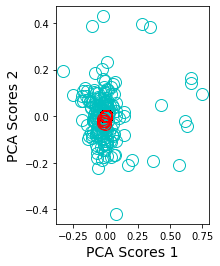

Horizontal and vertical range of cluster scores:
 1 red [0.01313422] [0.0300995]
Number of points in cluster  is  
 1 6
Refer to figure.  Add to cluster?  Yes: 1, No: 0 to stop adding points to cluster 1


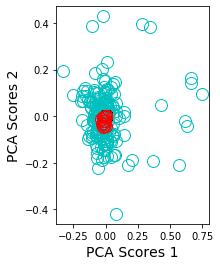

Horizontal and vertical range of cluster scores:
 1 red [0.03640242] [0.04758232]
Number of points in cluster  is  
 1 13
Refer to figure.  Add to cluster?  Yes: 1, No: 0 to stop adding points to cluster 0


Enter 1 to construct a new cluster, 0 to stop adding clusters 1
Adding points to cluster 
 2


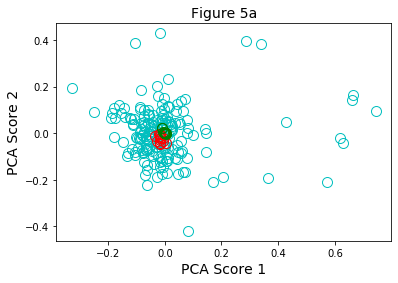

Horizontal and vertical range of cluster  #s scores   
 2 green [0.01422839] [0.0223565]
Number of points in cluster  is  
 2 7
Refer to figure.  Add to cluster?  Yes: 1, No: 0 to stop adding points to cluster 0


Enter 1 to construct a new cluster, 0 to stop adding clusters 0




In [3]:
num_group_elements=np.zeros((1000,1))
group_elements=np.zeros((1000,100))

number_groups = 0 
iretry_groups = 1
while (iretry_groups == 1 and number_groups < 4): 
   
   itry_again_cluster = 1
   nit_center=0
   
   while (itry_again_cluster == 1):
       
      # Find the point with the highest density
      nit_center=nit_center+1
      number_groups = number_groups + 1 
      center_group_element[number_groups-1] = 0

      for i in range(0,npeaks):   

          # Check to see if the peak i has already been included in a cluster
          # or if the peak i is too close to a cluster
          ifound = 0 

          if (in_cluster[i] == 0):
             filler=0                                      
          else:
             ifound = 1           
          if (ifound == 0): 
             # Find the point i with the smallest radius to the nearest number_neighbors
             # or equivalently the point i with the highest surrounding
             # density of scores
             if (dist_neighbor[i] < radius_group[number_groups-1]):
                center_group_element[number_groups-1] = i+1   #Debate over whether it should be +1 or not
                radius_group[number_groups-1] = dist_neighbor[i]
    
      kc = int(center_group_element[number_groups-1])

      if (kc == 0):
         print('\n')
         print('No new cluster center was not found \n')
         print('Try decreasing value of variable fraction_radius_all_scores \n')
         print('Current value of fraction_radius_all_scores  \n',fraction_radius_all_scores)
         print('Enter 0 to stop finding new clusters \n')
         itry_again_cluster = int(input('Enter 1 to continue finding cluster by decreasing fraction_radius_all_scores '))
         if (itry_again_cluster == 1):
            fraction_radius_all_scores = float(input('Enter new value of fraction_radius_all_scores: Suggested range [.25,1] '))
        
         number_groups = number_groups - 1
      else:
         itry_again_cluster = 0 
 
   if (kc > 0):
      number_in_cluster = 1
      cluster_group[:] = 0 
      cluster_group[0] = kc
      in_cluster[kc-1] = 1 #I added the -1
      
      rad_search = fraction_radius_group*radius_group[number_groups-1]
      iretry = 1
      nit = 0
      nit_progress = 0
      
      print('Adding points to cluster \n',number_groups)
      while (iretry == 1): 
         
         nit = nit + 1
       
         close_points = 0
         number_in_cluster_new = int(number_in_cluster)
         for i in range(0,int(number_in_cluster)):
             ii = int(cluster_group[i])

             jj = int(0)
             radius_exceeded = 0
             while (jj < npeaks and radius_exceeded == 0):
                 jj = jj + 1 
                 ic = int(points_neighbor_sorted[ii-1,jj-1]) # ic will be 1 less in python than matlab
                 if (dist_neighbor_sorted[ii-1,jj-1] < rad_search):  #I added Undecided on what to do with this
                    
                    # Determine if candidate point ic is far enough way
                    # from other clusters
                    ifound = 0
                    if (number_groups > 1):
                       #radius_all_scores = dist_neighbor_sorted[int(kc),npeaks-1] #I added this
                       min_distance_neighboring_cluster = minimum_distance_cluster_parameter*radius_all_scores
                    
                    if (in_cluster[ic] == 0): #I added the -1
                       close_points = close_points + 1 
                    else:
                        ifound = 1             

                    if (ifound == 0):
                       number_in_cluster_new = number_in_cluster_new + 1  
                       cluster_group[number_in_cluster_new-1] = ic+1 #cluster_group is 1 less in python so a +1 is added
                       in_cluster[ic] = 1  #ic is 1 less in python than matlab, so adding -1 shouldnt be necessary    
          
                 else:                     
                    radius_exceeded = 1
                        
         no_change = 0
         if (number_in_cluster == number_in_cluster_new  and nit > 1):
             nit_progress = nit_progress + 1
             print('No additional points were added to cluster \n')
             if (close_points == 0):
                print('Suggest increasing parameter fraction_radius_group \n')
                print('to retry adding additional points to cluster \n')
                print('Current value of fraction_radius_group is \n',fraction_radius_group)
                print('Enter 0 to keep value of fraction_radius_group \n')
                itry_again = 0
                itry_again = int(input('Enter 1 to change value of fraction_radius_group '))
                if (itry_again == 1):
                   print('Suggested values for fraction_radius_group [.6 1.5] \n')
                   fraction_radius_group = float(input('Enter value of fraction_radius_group '))
                   rad_search = fraction_radius_group*radius_group[number_groups-1]
                
             else:
                print('Suggest decreasing minimum distance parameter minimum_distance_cluster_parameter \n')
                print('to be maintained to nearest cluster \n')
                print('Current value of minimum_distance_cluster_parameter is  \n',minimum_distance_cluster_parameter)
                print('Enter 0 to keep value of minimum_distance_cluster_parameter \n')
                itry_again = 0
                itry_again = int(input('Enter 1 to change value of minimum_distance_cluster_parameter '))
                if (itry_again == 1):
                   print('Suggested values for minimum_distance_cluster_parameter [.05 .5] \n')
                   minimum_distance_cluster_parameter = float(input('Enter value of minimum_distance_cluster_parameter '))
                            
             no_change = 1    
          
         number_in_cluster = int(number_in_cluster_new)
            
         if (number_groups == 1):
            # radius_all_scores is a measure of the size of the entire set of
            # scores
            radius_all_scores = dist_neighbor_sorted[kc-1,npeaks-1] #I added the -1 
        
         if (no_change == 0):     
            if (number_groups == 1):
               minxscore = 1.e+20
               maxxscore = -1.e+20
               minyscore = 1.e+20
               maxyscore = -1.e+20
               for i in range(0,int(number_in_cluster)):
                   j = int(cluster_group[i])
                   xscoreplota[i] = xscore[j-1] #Added -1
                   yscoreplota[i] = yscore[j-1] #Added -1
                   minxscore = min(minxscore,xscoreplota[i])
                   maxxscore = max(maxxscore,xscoreplota[i])
                   minyscore = min(minyscore,yscoreplota[i])
                   maxyscore = max(maxxscore,yscoreplota[i])
               
               matplotlib.pyplot.subplot(1,2,1)
               plt.plot(xscore,yscore,'co', xscoreplota,yscoreplota,'ro',markersize=12, markerfacecolor='none')
               plt.xlabel('PCA Scores 1',fontsize=14)
               plt.ylabel('PCA Scores 2',fontsize=14)
               plt.show()
               print('Horizontal and vertical range of cluster scores:\n',number_groups,'red',maxxscore-minxscore,maxyscore-minyscore)
            
            if (number_groups == 2):
               minxscore = 1.e+20
               maxxscore = -1.e+20
               minyscore = 1.e+20
               maxyscore = -1.e+20
               for i in range(0,int(number_in_cluster)):
                   j = int(cluster_group[i])
                   xscoreplotb[i] = xscore[j-1]
                   yscoreplotb[i] = yscore[j-1]
                   minxscore = min(minxscore,xscoreplotb[i])
                   maxxscore = max(maxxscore,xscoreplotb[i])
                   minyscore = min(minyscore,yscoreplotb[i])
                   maxyscore = max(maxxscore,yscoreplotb[i])
               
               plt.plot(xscore,yscore,'co',xscoreplota,yscoreplota,'ro',xscoreplotb,yscoreplotb,'go',markersize=10, markerfacecolor='none')
               plt.xlabel('PCA Score 1',fontsize=14)
               plt.ylabel('PCA Score 2',fontsize=14)
               plt.title('Figure 5a',fontsize=14)
               plt.show()
               print('Horizontal and vertical range of cluster  #s scores   \n',number_groups,'green',maxxscore-minxscore,maxyscore-minyscore)
            
            if (number_groups == 3):
               minxscore = 1.e+20
               maxxscore = -1.e+20
               minyscore = 1.e+20
               maxyscore = -1.e+20
               for i in range(0,int(number_in_cluster)):
                   j = int(cluster_group[i])
                   xscoreplotc[i] = xscore[j-1]
                   yscoreplotc[i] = yscore[j-1]
                   minxscore = min(minxscore,xscoreplotc[i])
                   maxxscore = max(maxxscore,xscoreplotc[i])
                   minyscore = min(minyscore,yscoreplotc[i])
                   maxyscore = max(maxxscore,yscoreplotc[i])
               
               plt.plot(xscore,yscore,'co',xscoreplota,yscoreplota,'ro',xscoreplotb,yscoreplotb,'go',xscoreplotc,yscoreplotc,'mo',markersize=10, markerfacecolor='none')
               plt.xlabel('PCA Score 1',fontsize=12)
               plt.ylabel('PCA Score 2',fontsize=12)
               plt.show()
               print('Horizontal and vertical range of cluster  of #s scores   \n',number_groups,'magenta',maxxscore-minxscore,maxyscore-minyscore)
            
            if (number_groups == 4):
               minxscore = 1.e+20
               maxxscore = -1.e+20
               minyscore = 1.e+20
               maxyscore = -1.e+20
               for i in range(0,int(number_in_cluster)):
                   j = int(cluster_group[i])
                   xscoreplotd[i] = xscore[j-1]
                   yscoreplotd[i] = yscore[j-1]
                   minxscore = min(minxscore,xscoreplotd[i])
                   maxxscore = max(maxxscore,xscoreplotd[i])
                   minyscore = min(minyscore,yscoreplotd[i])
                   maxyscore = max(maxxscore,yscoreplotd[i])
               
               plt.plot(xscore,yscore,'co',xscoreplota,yscoreplota,'ro',xscoreplotb,yscoreplotb,'go',xscoreplotc,yscoreplotc,'mo',xscoreplotd,yscoreplotd,'bo',markersize=10, markerfacecolor='none')
               plt.xlabel('PCA Score 1',fontsize=12)
               plt.ylabel('PCA Score 2',fontsize=12)
               plt.show()
               print('Horizontal and vertical range of cluster  #s scores   \n',number_groups,'blue',maxxscore-minxscore,maxyscore-minyscore)    
                   
         print('Number of points in cluster  is  \n',number_groups,number_in_cluster)
         iretry = int(input('Refer to figure.  Add to cluster?  Yes: 1, No: 0 to stop adding points to cluster '))
     
      if (nit_progress > 0):
          
         if (fraction_radius_group != fraction_radius_group_orig):
            print('Return fraction_radius_group to its original value?  \n',fraction_radius_group_orig)
            print('Enter 0 to keep value of fraction_radius_group \n')
            iorig = int(input('Enter 1 to return fraction_radius_group to its original value '))
            if (iorig == 1):
               fraction_radius_group = fraction_radius_group_orig    
         
         if (minimum_distance_cluster_parameter != minimum_distance_cluster_parameter_orig):
            print('Return minimum_distance_parameter_cluster to its original value?  ',minimum_distance_cluster_parameter_orig)
            print('Enter 0 to keep value of minimum_distance_parameter_cluster \n')
            iorig = int(input('Enter 1 to return minimum_distance_parameter_cluster to its original value '))
            if (iorig == 1):
               minimum_distance_cluster_parameter = minimum_distance_cluster_parameter_orig
      
      cluster_group=np.trim_zeros(cluster_group, trim='b')
      cpoints_sort=cluster_group.argsort(axis=0)
      cluster_sort=cluster_group[cpoints_sort]
      cluster_sort=np.ravel(cluster_sort) #This will pull the list of cluster indices out of double brackets. 
    
      num_group_elements[number_groups-1] = number_in_cluster
      num_group_elements=np.ravel(num_group_elements)
    
      for i in range(0,int(num_group_elements[number_groups-1])):
          group_elements[number_groups-1,i] = cluster_sort[i]
        
      print('\n')
      if (number_groups < 4):
         iretry_groups = int(input('Enter 1 to construct a new cluster, 0 to stop adding clusters '))
      else:
         iretry_groups = 0
      
   else:
      iretry_groups = 0

num_group_elements=np.trim_zeros(num_group_elements, 'b')
group_elements = group_elements[~np.all(group_elements == 0, axis=1)]
 
print('\n')
###########################################################################
# End: Clustering algorithm
########################################################################### 

Overlaying spikes 



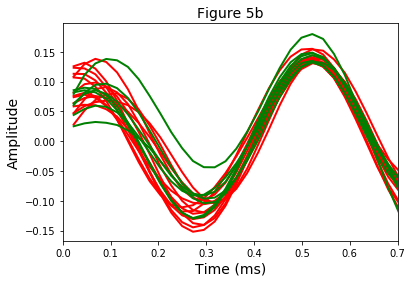

Press enter to continue 



In [4]:
### #plt.plot similar spikes.  The spikes are overlayed to match the peak to view
# how similar they are.
###########################################################################
#This entire section is noteworthy in that i is 1 larger than usual 


ngroupsplot = int(min(6,number_groups))
    
if (ioverlay == 1):
   print('Overlaying spikes \n')    
   mingx = 1.e+20
   maxgx = -1.e+20
   for i in range(1,ngroupsplot+1): #I added a +1 because i cannot be 0 due to if i%7 
       ypkk_average = np.zeros((int(maxdiste+maxdistb+1),1))
       for k in range(0,int(num_group_elements[i-1])): #I added a -1
           kk = int(group_elements[i-1,k]) #I added a -1
           ijk = 0
           xpkk = np.zeros((int(maxdiste+maxdistb+1),1))
           ypkk = np.zeros((int(maxdiste+maxdistb+1),1))
            
           for j in range(int(peak[kk-1]-maxdistb-1),int(peak[kk-1]+maxdiste)):
               ijk = ijk +1
               xpkk[ijk-1] = ijk
               ypkk[ijk-1] = ya[j,0]
               ypkk_average[ijk-1] = ypkk_average[ijk-1] + ypkk[ijk-1]   
            
           if (i%7 == 1):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk))
               plt.plot(1000.*xpkk*dt,ypkk,'r-',linewidth=2)
               plt.axis([0,ap_before+ap_after, mingx ,maxgx])
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                  
               plt.xlabel('Time (ms)',fontsize=14)
               plt.ylabel('Amplitude',fontsize=14)
               plt.title('Figure 5b',fontsize=14)
            
           if (i%7 == 2):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk)) 
               plt.plot(1000.*xpkk*dt,ypkk,'g-',linewidth=2)
               plt.axis([0,ap_before+ap_after,mingx,maxgx])
               
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                  
           if (i%7 == 3):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk)) 
               plt.plot(1000.*xpkk*dt,ypkk,'m-',linewidth=2)
               plt.axis([0,ap_before+ap_after,mingx,maxgx])
               
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                  
             
           if (i%7 == 4):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk)) 
               plt.plot(1000.*xpkk*dt,ypkk,'b-',linewidth=2)
               plt.axis([0,ap_before+ap_after,mingx,maxgx])
               
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                  
            
           if (i%7 == 5):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk)) 
               plt.plot(1000.*xpkk*dt,ypkk,'y-',linewidth=2)
               plt.axis([0,ap_before+ap_after,mingx,maxgx])
               
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                  
            
           if (i%7 == 6):
               mingx = min(mingx,1.1*min(ypkk))
               maxgx = max(maxgx,1.1*max(ypkk)) 
               plt.plot(1000.*xpkk*dt,ypkk,'c-',linewidth=2)
               plt.axis([0,ap_before+ap_after,mingx,maxgx])
               
               if (k == num_group_elements[i-1]):
                  ypkk_average = ypkk_average/float(num_group_elements[i-1])
                  plt.plot(1000.*xpkk*dt,ypkk_average,'k-',linewidth=2)
                
plt.show()

print('Press enter to continue \n') 

###########################################################################
# End:plt.plot similar spikes. 
###########################################################################


Plotting time range and spike types 

Number of types of spikes  
 2


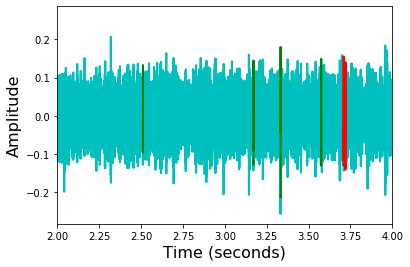

Press enter to continue 





In [5]:
###########################################################################
#plt.plotting selected colored-coded spikes interspersed among time range
# of spikes
###########################################################################  
print('Plotting time range and spike types \n')
print('Number of types of spikes  \n',number_groups)
    
distmax_min = int(max(xpk) - min(xpk))            
plt.plot(xpk,ypk,'c-',linewidth=2)
plt.axis([min(xpk),min(xpk)+2.0,min(ypk),max(ypk)])
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Amplitude',fontsize=16)

freq = np.zeros((1000,number_groups))
    
ijkt = 0

xpkks = np.zeros((100000,1))
ypkks = np.zeros((100000,1))

for i in range(1,number_groups+1):  #i is 1 more than it should be 

    for k in range(0,int(num_group_elements[i-1])):    #i is 1 more than it should be 
              
        kk = int(group_elements[i-1,k])
        # beginpeak firstneg negpeak secondneg firstzero beghalfheight peak endhalfheight endpeak      
        distancebeginpeak = int(peak[kk-1] - beginpeak[kk-1])
        
        ijk = 0
        xpkk = np.zeros((int(endpeak[kk-1]-beginpeak[kk-1]+1),1))
        ypkk = np.zeros((int(endpeak[kk-1]-beginpeak[kk-1]+1),1))

        for j in range(int(beginpeak[kk-1])-1,int(endpeak[kk-1])):
                    ijk = ijk +1
                    xpkk[ijk-1] = (ijk+beginpeak[kk-1])*dt
                    ypkk[ijk-1] = ya[j,0]
                    if (i == 1):
                       ijkt = ijkt + 1
                       xpkks[ijkt-1] = xpkk[ijk-1]
                       ypkks[ijkt-1] = ypkk[ijk-1]
            
        if (i%7 == 1):
            plt.plot(xpkk,ypkk,'r-',linewidth=2)
            
        if (i%7 == 2):
            plt.plot(xpkk,ypkk,'g-',linewidth=2)    
        
        if (i%7 == 3):
            plt.plot(xpkk,ypkk,'m-',linewidth=2)
              
        if (i%7 == 4):
            plt.plot(xpkk,ypkk,'b-',linewidth=2)        
        
        if (i%7 == 5):
            plt.plot(xpkk,ypkk,'y-',linewidth=2)
            
        if (i%7 == 6):
            plt.plot(xpkk,ypkk,'c-',linewidth=2)
            
plt.show()
print('Press enter to continue \n')
print('\n')
###########################################################################
# End:plt.plotting selected colored-coded spikes 
###########################################################################

In [184]:
###########################################################################
# Calculating interspike intervals and frequencies
###########################################################################

print('\n')
print('Calculating interspike intervals and frequencies \n')
freqmin = 10. # Minimum frequency
freqmax = 120. # Maximum frequency
print('Minimum frequency used  \n',freqmin)
print('Maximum frequency used  \n',freqmax)

number_isi=np.zeros((number_groups,1))
xisi1=np.zeros((100,number_groups))
yisi1=np.zeros((100,number_groups))
yisif=np.zeros((100,number_groups))

for i in range(0,int(number_groups)):

    numfreq = 0
    kkij = 0
    number_isi[i] = 0
    for k in range(0,int(num_group_elements[i])-1):
        kk = int(group_elements[i,k])
        kkp = int(group_elements[i,k+1])
        idif = peak[kkp-1]-peak[kk-1]
        spiketime = float(idif)*dt
        freq[k,i] = 1./spiketime
        numfreq = numfreq + 1
        
        if (spiketime >= 1./freqmax and spiketime <= 1./freqmin ):
            kkij = kkij + 1
            xisi1[kkij-1,i] = .5*(peak[kkp-1]+peak[kk-1])*dt
            yisi1[kkij-1,i] = spiketime
            yisif[kkij-1,i] = 1.0/spiketime
            number_isi[i] = kkij
         
    print('Total number of frequencies is  for group  \n',numfreq,i)
    
         
#number_isi=np.expand_dims(number_isi.ravel(),axis=1)
#xisi1=np.expand_dims(xisi1.ravel(),axis=1)
#yisi1=np.expand_dims(yisi1.ravel(),axis=1)
#yisi1=yisi1.ravel()
#yisif=np.expand_dims(yisif.ravel(),axis=1)
#zeros_column=np.zeros((100,1)).ravel()
#xisi1=np.hstack((xisi1,zeros_column))
#yisi1=np.hstack((yisi1,zeros_column))
#yisif=np.hstack((yisif,zeros_column))
#number_isi=np.hstack((number_isi,zeros_column))
###########################################################################
# End: Calculating interspike intervals and frequencies
###########################################################################



Calculating interspike intervals and frequencies 

Minimum frequency used  
 10.0
Maximum frequency used  
 120.0
Total number of frequencies is  for group  
 12 0
Total number of frequencies is  for group  
 6 1


2
Creating plots for group  
 1
0.013151927437641722




Creating plots for group  
 1
Standard deviation of Interspike Interval scores for Group  is #5.2f ms 
 0 16.037699846271472
Total number of interspike intervals is  for group  
 2 0


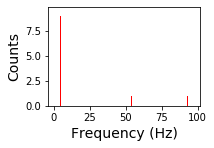

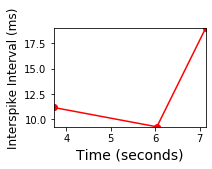

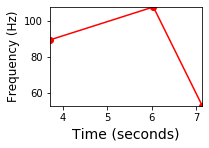

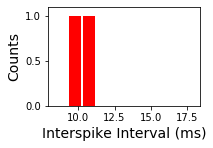

Plotting information for group  
 0
Press enter to continue 

Too few spikes to construct interspike interval and frequency histograms for group  
 2


In [187]:
# Plotting four window frame for each spike type
# Upper left window pane:plt.plot of Spike type interspersed with time interval
# Lower left window pane:plt.plot of interspike interval over time
# Upper right window pane: Distribution of firing frequencies
# Lower right window pane: Distribution of interspike intervals
###########################################################################
interval_freq = 10
xisi=np.zeros((interval_freq,1))
xfreq = np.zeros((interval_freq,1))
sts = ['r-o','g-o','m-o','b-o','y-o','c-o']
spltb = ['r','g','m','b','y','c']
num_skip = 3  
print('\n')

for kk in range(0,number_groups):
    if (number_isi[kk] > 1):
       print('Creating plots for group  \n',kk+1) 
       isimin = float(1e20)
       isimax = float(-1e20)
       isimean = 0.0
       isimean2 = 0.0
       for ij in range(0,int(number_isi[kk])): #I added a -1
           isimin = min(isimin,yisi1[ij,kk])
           isimax = max(isimax,yisi1[ij,kk])
           isimean = isimean + float(yisi1[ij,kk])
           isimean2 = isimean2 + yisi1[ij,kk]**2
       fnum = float(number_isi[kk])
       isimean = isimean/fnum
       standard_deviation = sqrt((isimean2 - (isimean**2)/fnum)/(fnum-1))
       print('Standard deviation of Interspike Interval scores for Group  is #5.2f ms \n',kk,1000.*standard_deviation)
       disi = (isimax - isimin)/float(interval_freq)
       binisi = np.zeros((interval_freq,1))
       ijbinisi = 0
       for ijk in range(0,int(interval_freq)):
           isi_low = isimin + float(ijk-1)*disi
           isi_high = isimin + float(ijk)*disi
           xisi[ijk] = isimin + (float(ijk)-.5)*disi
           for ij in range(0,int(number_isi[kk])):  
               if (yisi1[ij,kk] >= isi_low and yisi1[ij,kk] < isi_high):
                  binisi[ijk] = binisi[ijk] + 1.0
                  ijbinisi = ijbinisi + 1
               
       print('Total number of interspike intervals is  for group  \n',ijbinisi,kk)

       freqminc = 1e10
       freqmaxc = -1e10
       for ij in range(0,int(num_group_elements[kk])-1):
           ff = freq[ij,kk]
           freqminc = min(freqminc,freq[ij,kk])
           freqmaxc = max(freqmaxc,freq[ij,kk])
       
       freqmin = max(freqmin,freqminc)
       freqmax = min(freqmax,freqmaxc)

       dfreq = (freqmax-freqmin)/float(interval_freq)
       ijbin = 0
       binfreq = np.zeros((interval_freq,1))
       for ijk in range(0,int(interval_freq)):
           freq_low = freqmin + float(ijk-1)*dfreq
           freq_high = freqmin + float(ijk)*dfreq
           xfreq[ijk] = freqmin + (float(ijk)-.5)*dfreq
           for ij in range(0,int(num_group_elements[kk])):
               if (freq[ij,kk] >= freq_low and freq[ij,kk] < freq_high):
                   binfreq[ijk] = binfreq[ijk] + 1
                   ijbin = ijbin + 1
       
       sts = str(sts[kk])
        
       xisiif = np.zeros((int(number_isi[kk]),1))
       yisiif = np.zeros((int(number_isi[kk]),1))   
       for ijka in range(0,int(number_isi[kk])):
         xisiif[ijka] = xisi1[ijka,kk]
         yisiif[ijka] = yisif[ijka,kk]

       aaa = min(xisiif)
       bbb = max(xisiif)
       ccc = min(yisiif)
       ddd = max(yisiif)
      
       matplotlib.pyplot.subplot(2,2,2)
       minxfreq = min(xfreq)
       maxxfreq = max(xfreq)
       distxfreq = maxxfreq - minxfreq
       maxbin = max(binfreq)
       spltb_call=str(spltb[kk])
       plt.bar(xfreq.ravel(),binfreq.ravel(),color=spltb_call)
       plt.axis([minxfreq-.1*distxfreq ,maxxfreq+.1*distxfreq ,0 ,1.1*maxbin])
       plt.xlabel('Frequency (Hz)',fontsize=14)
       plt.ylabel('Counts',fontsize=14)
       plt.show()
        
       if (kk == 2):
           for ijk in range(0,int(interval_freq)):
               xxa = xfreq[ijk]
               yya = binfreq[ijk]
       
       xisii = np.zeros((int(number_isi[kk]),1))
       yisii = np.zeros((int(number_isi[kk]),1))
    
       xisii_avg = np.zeros((int(number_isi[kk]),1))
       yisii_avg = np.zeros((int(number_isi[kk]),1))
       freq_avg = np.zeros((int(number_isi[kk]),1))
       
       for ijka in range(0,int(number_isi[kk])):
         xisii[ijka] = xisi1[ijka,kk]
         yisii[ijka] = yisi1[ijka,kk]

         num_avg = 0
         xisii_avg[ijka] = 0.0
         yisii_avg[ijka] = 0.0
         for ijkb in range(int(max(ijka-num_skip,1)-1),int(min(ijka+num_skip,number_isi[kk]))):
             xisii_avg[ijka] = xisii_avg[ijka] + xisi1[ijkb,kk]            
             yisii_avg[ijka] = yisii_avg[ijka] + yisi1[ijkb,kk]
             num_avg = num_avg + 1
         
         xisii_avg[ijka] = xisii_avg[ijka]/float(num_avg)
         yisii_avg[ijka] = yisii_avg[ijka]/float(num_avg)
         freq_avg[ijka] = 1./yisii_avg[ijka]
       
       ijkc = 0
       for ijka in np.arange(num_skip,int(number_isi[kk]-num_skip),num_skip):
           ijkc = ijkc + 1
       
       xisiib_avg = np.zeros((ijkc,1))
       yisiib_avg = np.zeros((ijkc,1))
       freqb_avg = np.zeros((ijkc,1))
       
       ijkc = 0
       for ijka in np.arange(num_skip,int(number_isi[kk]-num_skip),num_skip):
           ijkc = ijkc + 1
           xisiib_avg[ijkc] = xisii_avg[ijka]
           yisiib_avg[ijkc] = yisii_avg[ijka]
           freqb_avg[ijkc] = freq_avg[ijka]
    
       matplotlib.pyplot.subplot(2,2,3)
        
       plt.plot(xisii,1000*yisii,sts)
       plt.axis([min(xisii),max(xisii),1000.*min(yisii),1000.*max(yisii)])
       plt.xlabel('Time (seconds)',fontsize=14)
       plt.ylabel('Interspike Interval (ms)',fontsize=12)
       plt.show()
       if (ijkc > 1):
          plt.plot(xisiib_avg,1000*yisiib_avg,'k-',linewidth=3)
          plt.axis([min(xisii),max(xisii),1000.*min(yisii),1000.*max(yisii)])
          plt.show()
       
       matplotlib.pyplot.subplot(2,2,1)    
        
       plt.plot(xisiif,yisiif,sts)
       plt.axis([aaa,bbb,ccc,ddd])
       plt.xlabel('Time (seconds)',fontsize=14)
       plt.ylabel('Frequency (Hz)',fontSize=12)
       plt.show()
       
       if (ijkc > 1):
          plt.plot(xisiib_avg,freqb_avg,'k-',linewidth=3)
          plt.axis([aaa,bbb,ccc,ddd])

       matplotlib.pyplot.subplot(2,2,4)
    
       spltb_call_c=str(spltb[kk])
       xisi=xisi.ravel()
       binisi=binisi.ravel()
       plt.bar(1000*xisi,binisi,color=spltb_call_c)
       distxim = max(1000*xisi) - min(1000*xisi)
       plt.axis([min(1000*xisi)-.1*distxim,max(1000*xisi)+.1*distxim,0,1.1*max(binisi)])
       plt.xlabel('Interspike Interval (ms)',fontsize=14)
       plt.ylabel('Counts',fontsize=14)
       plt.show()
       print('Plotting information for group  \n',kk)
       
       if (kk < number_groups):
          print('Press enter to continue \n')
    else:
        print('Too few spikes to construct interspike interval and frequency histograms for group  \n',number_groups)
        
plt.show()

In [186]:
print(isimean)

0.013151927437641722
